In [2]:
import numpy as np
import uproot
from sklearn.utils import shuffle
import glob
import os

In [ ]:
def process_files(file_name, n_max,typej):
    #open the input file and the tree
    tree = uproot.open(file_name + ":Out_Tree")

    #Exctract the jet and particle info 
    jets_truth = tree.arrays(
        ["true_jet_eta", "true_jet_phi", "true_jet_pt", "true_jet_truth_id", "true_jet_constituents_jetIndex"],
        library="np",
        entry_stop=n_max,
    )
    parts_truth = tree.arrays(
        ["particle_eta", "particle_phi", "particle_pt", "particle_pdgid"],
        library="np",
        entry_stop=n_max,
    )
    
    #Typically 100 is anough but you can check I will leavce the script which does this below 
    total_jets = 0
    max_num_particles = 100


    # First pass to determine max_num_particles and total_jets
    for en in range(n_max):
        jet_pt = jets_truth['true_jet_pt'][en]
        jet_id = jets_truth['true_jet_truth_id'][en]
        jet_idx = jets_truth['true_jet_constituents_jetIndex'][en]
        
        # Filter jets by pt > 100 GeV, |eta| < 2.5 and valid jet ID --> You need to change the pt 
        mask_pt = jet_pt > 100000
        
        if typej==1:
            mask_id = (jet_id == 1) | (jet_id == 2) | (jet_id == 3)
        else:
            mask_id = jet_id == 21

        combined_mask = mask_pt & mask_id 

        filtered_jet_indices = np.where(combined_mask)[0]
        
        if len(filtered_jet_indices)==1:
            total_jets += 1
            

            # constituent_indices = np.where(jet_idx == filtered_jet_indices)[0]
            # num_particles = len(constituent_indices)
            # if num_particles > max_num_particles:
            #      max_num_particles = num_particles

    print("The max number of particles: ", max_num_particles) 
    print("The  number of jets: ", total_jets)       

    # Initialize X and Y arrays
    X = np.zeros((total_jets, max_num_particles, 4))
    
    if typej==1:
        y = np.ones(total_jets)  # Initialize Y with ones since all are light quark jets
    else:
        y = np.zeros(total_jets)  # Initialize Y with ones since all are gluon jets
    
    jet_count = 0

    # Second pass to fill X and Y arrays
    for en in range(n_max):  
        jet_pt  = jets_truth['true_jet_pt'][en]
        jet_id  = jets_truth['true_jet_truth_id'][en]
        jet_idx = jets_truth['true_jet_constituents_jetIndex'][en]
        
        # Apply the same mask AGAIN if you need to increase jet pt you should 
        mask_pt = jet_pt > 100000 
        if typej==1:
            mask_id = (jet_id == 1) | (jet_id == 2) | (jet_id == 3)
        else:
            mask_id = jet_id == 21
        
        combined_mask = mask_pt & mask_id 
        jet_indices = np.where(combined_mask)[0]
       
        
        if len(jet_indices)==1:
            constituent_indices = np.where(jet_idx == jet_indices)[0] #Take only first jet you can also change a bit to take the first leading jet but its up to you
            eta = parts_truth['particle_eta'][en][constituent_indices]
            pt  = parts_truth['particle_pt'][en][constituent_indices]
            pt_GeV = pt/1000
            phi = parts_truth['particle_phi'][en][constituent_indices]
            pid = parts_truth['particle_pdgid'][en][constituent_indices]

            num_particles = len(constituent_indices)
            X[jet_count, :num_particles, 0] = pt_GeV[:num_particles]
            X[jet_count, :num_particles, 1] = eta[:num_particles]
            X[jet_count, :num_particles, 2] = phi[:num_particles]
            X[jet_count, :num_particles, 3] = pid[:num_particles]
                            
            jet_count += 1
    
    print(jet_count)
            
    return X, y

In [ ]:
def save_to_npz(X, y, output_file):
    np.savez(output_file, X=X, y=y)

In [ ]:
## Process gluon and quark files
input_file = "/srv01/agrp/annai/annai/QURK-GLUON/samples_produce/Cocoa/Cocoa_Zjets/Herwig/Zg/Zg_total_herwig.root"
output_file = "Zglujets_total_herwig.npz"
events = 200000
jet_type = 0 #Change the JET TYPE for Zq samples to 1!!!
X,y = process_files(input_file, events,jet_type)
save_to_npz(X,y,output_file)

In [ ]:
def load_data(files):
    data = np.load(files)
    X = data['X']
    y = data['y']
    return X, y

In [ ]:
def shuffle_data(X, y):
    X_shuffled, y_shuffled = shuffle(X, y, random_state=42)
    return X_shuffled, y_shuffled

In [ ]:
def save_shuffled_data(X, y, output_prefix, jets_per_file):
    total_jets = X.shape[0]
    num_files = (total_jets + jets_per_file - 1) // jets_per_file  # Calculate number of files needed
    
    for i in range(num_files):
        start_index = i * jets_per_file
        end_index = min(start_index + jets_per_file, total_jets)
        X_part = X[start_index:end_index]
        y_part = y[start_index:end_index]
        output_file = f"{output_prefix}_{i}.npz"
        np.savez(output_file, X=X_part, y=y_part)
        print(f"Saved {output_file} with {X_part.shape[0]} jets")

In [ ]:
# Example usage
quark_files = "Zqjets_total.npz"
gluon_files = "Zglujets_total.npz"

# Load data from quark and gluon files
X_quark, y_quark = load_data(quark_files)
X_gluon, y_gluon = load_data(gluon_files)

# Concatenate quark and gluon data
X = np.vstack((X_quark, X_gluon))
y = np.concatenate((y_quark, y_gluon))

# Shuffle the data
X_shuffled, y_shuffled = shuffle_data(X, y)

# Save the shuffled data into multiple files with a specified number of jets per file
jets_per_file = 10000
save_shuffled_data(X_shuffled, y_shuffled, "shuffled_output_Zqglu", jets_per_file)

In [22]:
# import re 
# # Define the path to your text file
# file_path = '/srv01/agrp/annai/annai/QURK-GLUON/PartNet_Local/logs/error-test-Old-kin.log'
# file_path_2 = '/srv01/agrp/annai/annai/QURK-GLUON/PartNet_Local/logs/error-test-Old-kinpid.log'


# # Regular expression to capture lines with "297it" and extract AvgLoss
# pattern = re.compile(r"^(506)it.*?AvgLoss=([0-9.]+)")

# # Initialize an empty list to store the extracted values
# AvrLoss = []
# current = None

# AvrLoss_kinpid = []
# current_kinpid = None

# # Iterate over each line in the log
# with open(file_path, 'r') as file:
#     for line in file:
#         match = pattern.search(line)
#         if match:
#             # Update current_avg_loss with the latest value
#             current = float(match.group(2))
            
#         elif current is not None and line.strip() == "":
#             # If the line is blank, store the last seen AvgLoss value
#             AvrLoss.append(current)
#             current = None

# # After the loop, append the last seen AvgLoss value if still in sequence
# if current is not None:
#     AvrLoss.append(current)


# print(AvrLoss)

# # Iterate over each line in the log
# with open(file_path_2, 'r') as file:
#     for line in file:
#         match = pattern.search(line)
#         if match:
#             # Update current_avg_loss with the latest value
#             current_kinpid = float(match.group(2))
            
#         elif current_kinpid is not None and line.strip() == "":
#             # If the line is blank, store the last seen AvgLoss value
#             AvrLoss_kinpid.append(current_kinpid)
#             current_kinpid = None

# # After the loop, append the last seen AvgLoss value if still in sequence
# if current_kinpid is not None:
#     AvrLoss_kinpid.append(current_kinpid)

# print(AvrLoss_kinpid)


[0.50263, 0.48824, 0.48509, 0.48172, 0.48124, 0.47806, 0.47591, 0.47521, 0.4739, 0.47274, 0.47235, 0.47141, 0.47116, 0.47129, 0.46931, 0.46934, 0.469, 0.46845, 0.46831, 0.46734, 0.46664, 0.4662, 0.46667, 0.46607, 0.46519, 0.46363, 0.46613, 0.46382, 0.46436, 0.46254, 0.46178, 0.46207, 0.46154, 0.46021, 0.45989, 0.45843, 0.45434, 0.45263, 0.44841, 0.44611, 0.44311, 0.44154, 0.43993, 0.43876, 0.43614, 0.43707, 0.43558, 0.435, 0.43505, 0.43402]
[0.48989, 0.47752, 0.47389, 0.47154, 0.46636, 0.46609, 0.46281, 0.46133, 0.45989, 0.45804, 0.45751, 0.4568, 0.4552, 0.4563, 0.45448, 0.45425, 0.45303, 0.45326, 0.45171, 0.45173, 0.45073, 0.45167, 0.44937, 0.44881, 0.44856, 0.44757, 0.44791, 0.44559, 0.44527, 0.44659, 0.44389, 0.44322, 0.44244, 0.44131, 0.44045, 0.43671, 0.43072, 0.42726, 0.42344, 0.41675, 0.41307, 0.41019, 0.40694, 0.40308, 0.40229, 0.40003, 0.39905, 0.39761, 0.39703, 0.39624]


In [44]:
# # file_path = '/srv01/agrp/annai/annai/QURK-GLUON/PartNet_Local/error-hw_hgpflow_kin.log'
# # file_path_2 = '/srv01/agrp/annai/annai/QURK-GLUON/PartNet_Local/error-py_hgpflow_kinpid.log'
# import re 
# file_path = '/srv01/agrp/annai/annai/QURK-GLUON/PartNet_Local/logs//error-test-Old-kin.log'
# file_path_2 = '/srv01/agrp/annai/annai/QURK-GLUON/PartNet_Local/logs//error-test-Old-kinpid.log'


# avr_los = []

# with open(file_path, 'r') as file:
#     lines = file.readlines()
    
#     for i in range(len(lines) - 1):
#         # Match the "82it" lines
#         match = re.search(r"(389|388)it.*?AvgLoss=([0-9.]+)", lines[i])
#         if match and "y should be" in lines[i + 1]:
#             avr_los.append(float(match.group(1)))
# print(avr_los)   
# print("The minimum for kin  is: " + str(np.min(avr_los))) 
# print("The epoch is " + str(avr_los.index(np.min(avr_los))))


# avr_los_pid = []

# with open(file_path_2, 'r') as file:
#     lines = file.readlines()
    
#     for i in range(len(lines) - 1):
#         # Match the "82it" lines
#         match = re.search(r"^38[89]it.*?AvgLoss=([0-9.]+)", lines[i])
#         if match and "y should be" in lines[i + 1]:
#             avr_los_pid.append(float(match.group(1)))
# print(avr_los_pid)   
# print("The minimum for kinpid  is: " + str(np.min(avr_los))) 
# print("The epoch is " + str(avr_los.index(np.min(avr_los))))

[389.0, 389.0, 389.0, 389.0, 389.0, 389.0, 389.0, 389.0, 389.0, 389.0, 389.0, 389.0, 389.0, 389.0, 389.0, 389.0, 389.0, 389.0, 389.0, 389.0, 389.0, 389.0, 389.0, 389.0, 389.0, 389.0, 389.0, 389.0, 389.0, 389.0, 389.0, 389.0, 389.0, 389.0, 389.0, 389.0, 389.0, 389.0, 389.0, 389.0, 389.0, 389.0, 389.0, 389.0, 389.0, 389.0, 389.0, 389.0, 389.0, 389.0]
The minimum for kin  is: 389.0
The epoch is 0
[0.40975, 0.40428, 0.39635, 0.39591, 0.39473, 0.39091, 0.39259, 0.38767, 0.39076, 0.38735, 0.38664, 0.38565, 0.38973, 0.38837, 0.38679, 0.38552, 0.38496, 0.38328, 0.3919, 0.3907, 0.38624, 0.38376, 0.38479, 0.38695, 0.38914, 0.40063, 0.38491, 0.38489, 0.38587, 0.38507, 0.38917, 0.38609, 0.38664, 0.38628, 0.38468, 0.3855, 0.38638, 0.38734, 0.38659, 0.38927, 0.38811, 0.38979, 0.39005, 0.39036, 0.39035, 0.39089, 0.3907, 0.39143, 0.39253, 0.39075]
The minimum for kinpid  is: 389.0
The epoch is 0


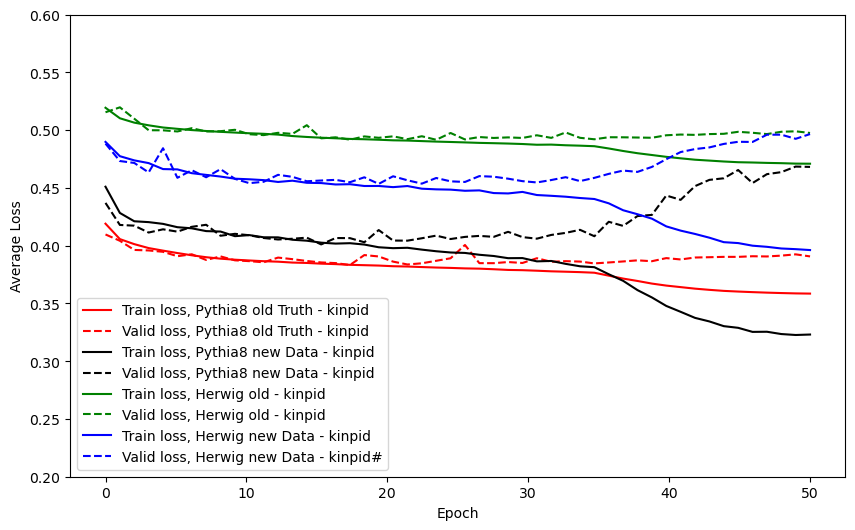

In [45]:
##This is for PLOTTING YOU CAN UNCOMMNET IT ONCE YOU WANT TO CHACK THE PREDICTIONS LOSS FUNCTION
#######################################
# import matplotlib.pyplot as plt
# import numpy as np
# x = np.linspace(0, 50, 50)

# #Pythia truth new samples
# y_py_new_kin_tr = [0.46553, 0.4452, 0.44027, 0.4352, 0.43449, 0.43274, 0.43272, 0.4302, 0.42942, 0.42729, 0.42912, 0.4262, 0.427, 0.42584, 0.42587, 0.42438, 0.4231, 0.42312, 0.42039, 0.42399, 0.4206, 0.4209, 0.42033, 0.41964, 0.41843, 0.4173, 0.41948, 0.41476, 0.41691, 0.41544, 0.41421, 0.41379, 0.41212, 0.41128, 0.41291, 0.40761, 0.40468, 0.39971, 0.39691, 0.39287, 0.38967, 0.388, 0.38592, 0.3819, 0.38288, 0.38228, 0.3796, 0.37904, 0.37949, 0.37888]
# y_py_new_kinpid_tr = [0.45109, 0.42837, 0.42117, 0.42043, 0.41892, 0.41604, 0.41507, 0.41266, 0.41227, 0.40827, 0.4092, 0.4073, 0.40723, 0.40518, 0.40435, 0.40264, 0.40185, 0.40219, 0.40101, 0.39867, 0.39789, 0.39821, 0.39662, 0.39522, 0.39414, 0.39376, 0.39217, 0.3911, 0.38922, 0.3893, 0.38647, 0.3868, 0.3843, 0.38221, 0.38141, 0.3753, 0.36961, 0.36156, 0.35522, 0.34787, 0.34277, 0.33753, 0.33444, 0.33036, 0.32892, 0.3254, 0.32552, 0.32353, 0.32271, 0.32311]

# y_py_new_kin_val = [0.43786, 0.43325, 0.4336, 0.42881, 0.42815, 0.42944, 0.43104, 0.42334, 0.43221, 0.42627, 0.4293, 0.42797, 0.42845, 0.42661, 0.42948, 0.4236, 0.42514, 0.42476, 0.4257, 0.4246, 0.4299, 0.41751, 0.42838, 0.42432, 0.42313, 0.42408, 0.42346, 0.42499, 0.42558, 0.42528, 0.42891, 0.42281, 0.4248, 0.4326, 0.4226, 0.43305, 0.43194, 0.42998, 0.43616, 0.43511, 0.44336, 0.44014, 0.4402, 0.44307, 0.44393, 0.44251, 0.44802, 0.44711, 0.44533, 0.4455]
# y_py_new_kinpid_val = [0.43707, 0.41798, 0.41737, 0.41141, 0.41421, 0.4122, 0.41637, 0.41813, 0.40863, 0.4103, 0.40908, 0.40669, 0.40539, 0.40604, 0.40698, 0.40112, 0.40666, 0.40657, 0.40301, 0.41356, 0.40448, 0.40438, 0.40647, 0.40874, 0.4058, 0.40764, 0.40851, 0.40769, 0.41203, 0.40745, 0.40611, 0.40933, 0.41112, 0.41377, 0.40822, 0.42073, 0.41716, 0.42569, 0.42669, 0.44347, 0.43972, 0.4516, 0.45702, 0.45839, 0.46554, 0.45426, 0.46196, 0.46371, 0.46853, 0.46824]

# #Herwig truth new samples 
# y_hw_new_kin_tr = [0.50263, 0.48824, 0.48509, 0.48172, 0.48124, 0.47806, 0.47591, 0.47521, 0.4739, 0.47274, 0.47235, 0.47141, 0.47116, 0.47129, 0.46931, 0.46934, 0.469, 0.46845, 0.46831, 0.46734, 0.46664, 0.4662, 0.46667, 0.46607, 0.46519, 0.46363, 0.46613, 0.46382, 0.46436, 0.46254, 0.46178, 0.46207, 0.46154, 0.46021, 0.45989, 0.45843, 0.45434, 0.45263, 0.44841, 0.44611, 0.44311, 0.44154, 0.43993, 0.43876, 0.43614, 0.43707, 0.43558, 0.435, 0.43505, 0.43402]
# y_hw_new_kinpid_tr = [0.48989, 0.47752, 0.47389, 0.47154, 0.46636, 0.46609, 0.46281, 0.46133, 0.45989, 0.45804, 0.45751, 0.4568, 0.4552, 0.4563, 0.45448, 0.45425, 0.45303, 0.45326, 0.45171, 0.45173, 0.45073, 0.45167, 0.44937, 0.44881, 0.44856, 0.44757, 0.44791, 0.44559, 0.44527, 0.44659, 0.44389, 0.44322, 0.44244, 0.44131, 0.44045, 0.43671, 0.43072, 0.42726, 0.42344, 0.41675, 0.41307, 0.41019, 0.40694, 0.40308, 0.40229, 0.40003, 0.39905, 0.39761, 0.39703, 0.39624]

# y_hw_new_kin_val = [0.52828, 0.47943, 0.49585, 0.47877, 0.48189, 0.47245, 0.47919, 0.47059, 0.46897, 0.47251, 0.47585, 0.46861, 0.47137, 0.4687, 0.47123, 0.46905, 0.47204, 0.47016, 0.47232, 0.4631, 0.47881, 0.46813, 0.4706, 0.46846, 0.46989, 0.46958, 0.47088, 0.46923, 0.47072, 0.47031, 0.47852, 0.47389, 0.47147, 0.46549, 0.47142, 0.47218, 0.47425, 0.47509, 0.47442, 0.47544, 0.47895, 0.47735, 0.48231, 0.47986, 0.48145, 0.48211, 0.4836, 0.48339, 0.48425, 0.48281]
# y_hw_new_kinpid_val = [0.48837, 0.47333, 0.47167, 0.46346, 0.4844, 0.45882, 0.46537, 0.45927, 0.4663, 0.4579, 0.45417, 0.45536, 0.46138, 0.45964, 0.45581, 0.45646, 0.45702, 0.45498, 0.45924, 0.45354, 0.46012, 0.45666, 0.45375, 0.45864, 0.45574, 0.45521, 0.46027, 0.45974, 0.45804, 0.4559, 0.45479, 0.45687, 0.45933, 0.45594, 0.45876, 0.4622, 0.46507, 0.46393, 0.46822, 0.4749, 0.4811, 0.48369, 0.48512, 0.48814, 0.48998, 0.48984, 0.49612, 0.49614, 0.49256, 0.49667]

# #Old Pythia 
# y_py_old_kin_tr=[0.43294, 0.41895, 0.41048, 0.40685, 0.40515, 0.4037, 0.40261, 0.40181, 0.40126, 0.40057, 0.40013, 0.39966, 0.39924, 0.39885, 0.39847, 0.39824, 0.39798, 0.39775, 0.3974, 0.39706, 0.39668, 0.39633, 0.39626, 0.39604, 0.39563, 0.39562, 0.395, 0.39513, 0.39467, 0.39463, 0.39394, 0.39367, 0.3937, 0.3934, 0.3931, 0.39109, 0.38951, 0.38802, 0.38676, 0.38531, 0.38427, 0.38373, 0.38289, 0.38251, 0.38202, 0.38177, 0.38119, 0.38138, 0.38124, 0.38073]
# y_py_old_kinpid_tr=[0.41907, 0.40573, 0.40138, 0.39797, 0.39576, 0.39366, 0.39172, 0.39005, 0.38879, 0.3879, 0.38722, 0.3866, 0.38618, 0.38541, 0.38509, 0.38447, 0.38408, 0.38346, 0.38315, 0.38282, 0.38225, 0.38199, 0.38153, 0.38111, 0.38079, 0.38037, 0.38014, 0.37964, 0.37904, 0.37882, 0.37836, 0.37784, 0.3775, 0.37714, 0.37662, 0.37408, 0.37155, 0.36948, 0.36722, 0.36549, 0.36416, 0.36283, 0.3618, 0.3609, 0.36032, 0.35982, 0.35938, 0.35902, 0.35872, 0.35855]

# y_py_old_kin_val = [0.42803, 0.41178, 0.41332, 0.40494, 0.40322, 0.40465, 0.40083, 0.4024, 0.40042, 0.4029, 0.39856, 0.40029, 0.3999, 0.41238, 0.39841, 0.39916, 0.39818, 0.39771, 0.40042, 0.39897, 0.40183, 0.39804, 0.39806, 0.39771, 0.39814, 0.40085, 0.39832, 0.39914, 0.39908, 0.40045, 0.40111, 0.4005, 0.39959, 0.39896, 0.39959, 0.39882, 0.40035, 0.39993, 0.39923, 0.40124, 0.39946, 0.40058, 0.40175, 0.40117, 0.40135, 0.40169, 0.40121, 0.40295, 0.40194, 0.40228]
# y_py_old_kinpid_val = [0.40975, 0.40428, 0.39635, 0.39591, 0.39473, 0.39091, 0.39259, 0.38767, 0.39076, 0.38735, 0.38664, 0.38565, 0.38973, 0.38837, 0.38679, 0.38552, 0.38496, 0.38328, 0.3919, 0.3907, 0.38624, 0.38376, 0.38479, 0.38695, 0.38914, 0.40063, 0.38491, 0.38489, 0.38587, 0.38507, 0.38917, 0.38609, 0.38664, 0.38628, 0.38468, 0.3855, 0.38638, 0.38734, 0.38659, 0.38927, 0.38811, 0.38979, 0.39005, 0.39036, 0.39035, 0.39089, 0.3907, 0.39143, 0.39253, 0.39075]

# #Old Herwig
# y_hw_old_kin_tr = [0.52321, 0.51271, 0.50996, 0.50829, 0.50683, 0.50597, 0.50517, 0.50465, 0.50419, 0.50371, 0.50328, 0.50272, 0.50269, 0.5022, 0.50199, 0.50171, 0.50141, 0.50126, 0.50091, 0.50083, 0.50054, 0.50034, 0.50003, 0.49989, 0.49953, 0.49941, 0.49919, 0.49891, 0.49887, 0.4985, 0.49829, 0.49818, 0.49788, 0.49749, 0.49743, 0.49584, 0.49448, 0.49337, 0.49222, 0.49115, 0.49013, 0.48964, 0.48889, 0.48846, 0.4882, 0.48777, 0.48757, 0.48713, 0.48728, 0.48688]
# y_hw_old_kinpid_tr = [0.51945, 0.51035, 0.50657, 0.50425, 0.50236, 0.5012, 0.50013, 0.49932, 0.4986, 0.49797, 0.49737, 0.4969, 0.49619, 0.49495, 0.49416, 0.49352, 0.49303, 0.49247, 0.49219, 0.49176, 0.49126, 0.49105, 0.49059, 0.49015, 0.48982, 0.48945, 0.48904, 0.48877, 0.48846, 0.48806, 0.48742, 0.48755, 0.48698, 0.48663, 0.48616, 0.4842, 0.48202, 0.48009, 0.47854, 0.47696, 0.47567, 0.47447, 0.4737, 0.47292, 0.4723, 0.47205, 0.47171, 0.47147, 0.47109, 0.47101]

# y_hw_old_kin_val= [0.52796, 0.51889, 0.51004, 0.5094, 0.50581, 0.50446, 0.50568, 0.50994, 0.5028, 0.50273, 0.50245, 0.50373, 0.50272, 0.51679, 0.50434, 0.50247, 0.50332, 0.50049, 0.5032, 0.50172, 0.5019, 0.50166, 0.50199, 0.50054, 0.50971, 0.50164, 0.50344, 0.49986, 0.50308, 0.5007, 0.50322, 0.50303, 0.5011, 0.50386, 0.5016, 0.50097, 0.50167, 0.50275, 0.50188, 0.5044, 0.50199, 0.50376, 0.50366, 0.50403, 0.50356, 0.50471, 0.50374, 0.50449, 0.50456, 0.50541]
# y_hw_old_kinpid_val= [0.51555, 0.51982, 0.50998, 0.5, 0.49992, 0.49893, 0.50176, 0.49893, 0.49917, 0.50037, 0.49652, 0.49576, 0.49776, 0.49683, 0.50435, 0.49299, 0.49386, 0.49181, 0.49463, 0.49345, 0.49469, 0.49226, 0.49478, 0.49173, 0.4976, 0.49201, 0.4941, 0.49331, 0.49379, 0.49331, 0.49563, 0.49338, 0.49808, 0.49343, 0.49216, 0.49393, 0.49387, 0.49367, 0.49347, 0.49563, 0.49625, 0.49597, 0.49666, 0.4969, 0.49862, 0.49779, 0.49666, 0.49866, 0.49906, 0.49762]

# #Pythia HGPFLOW 
# y_py_hgpflow_kin_val = [0.47788, 0.46176, 0.46754, 0.4618, 0.46529, 0.4572, 0.45337, 0.45357, 0.51608, 0.45252, 0.45927, 0.44929, 0.45094, 0.45075, 0.47596, 0.44615, 0.46611, 0.45535, 0.4619, 0.44702, 0.45071, 0.45186, 0.4711, 0.44927, 0.4528, 0.4534, 0.45601, 0.45066, 0.45014, 0.45452, 0.4557, 0.44918, 0.44926, 0.45197, 0.45163, 0.45167, 0.45443, 0.45469, 0.45333, 0.45769, 0.45625, 0.45698, 0.45932, 0.45782, 0.45997, 0.46146, 0.45878, 0.46046, 0.45906, 0.46089]
# y_py_hgpflow_kin_tr = [0.47959, 0.46484, 0.46008, 0.45934,0.45856, 0.45611,0.45186, 0.45385, 0.45345, 0.45145, 0.44928, 0.45042, 0.44922, 0.44841, 0.44793, 0.4478, 0.44756, 0.446, 0.44527, 0.44651, 0.44418, 0.44452, 0.44304, 0.44423, 0.44321, 0.44235, 0.44312, 0.44135, 0.44198, 0.44093, 0.44069, 0.43999, 0.43998, 0.43909, 0.4388, 0.43554, 0.43373, 0.42975, 0.42806, 0.42584, 0.42553, 0.42115, 0.42143, 0.41934, 0.41984, 0.41884, 0.41832, 0.41501, 0.41783, 0.417]

# y_py_hgpflow_kinpid_tr = [0.47625, 0.45986, 0.45784, 0.45391, 0.45391, 0.44798, 0.44791, 0.44759, 0.4438, 0.44357, 0.44335, 0.44251, 0.44097, 0.44005, 0.44141, 0.43927, 0.43928, 0.43744, 0.4383, 0.4366, 0.43579, 0.43682, 0.43574, 0.43613, 0.43523, 0.43372, 0.43498, 0.43117, 0.43353, 0.43249, 0.4324, 0.43148, 0.42984, 0.4301, 0.42853, 0.42644, 0.42361, 0.422, 0.41937, 0.41628, 0.41384, 0.41194, 0.41204, 0.41009, 0.40793, 0.40738, 0.40773, 0.40676, 0.40666, 0.40636]
# y_py_hgpflow_kinpid_val = [0.4593, 0.45337, 0.48477, 0.45547, 0.46072, 0.44673, 0.45629, 0.44354, 0.45746, 0.44439, 0.45354, 0.44319, 0.44475, 0.44403, 0.45911, 0.44756, 0.44721, 0.44214, 0.456, 0.44294, 0.47442, 0.44378, 0.46239, 0.4416, 0.44196, 0.44662, 0.4465, 0.4426, 0.44186, 0.44636, 0.44444, 0.44362, 0.44291, 0.44238, 0.45707, 0.4438, 0.44404, 0.44901, 0.44969, 0.44938, 0.44913, 0.45082, 0.45173, 0.45436, 0.45501, 0.45469, 0.45332, 0.45712, 0.45541, 0.45388]

# #Herwig HGPFLOW
# y_hw_hgpflow_kin_tr = [0.51627, 0.50816, 0.50619, 0.50404, 0.50406, 0.50057, 0.4998, 0.49849, 0.49768, 0.49677, 0.49572, 0.49619, 0.4949, 0.49497, 0.49513, 0.49305, 0.49319, 0.4936, 0.49363, 0.49224, 0.49186, 0.49284, 0.49145, 0.48976, 0.49222, 0.48964, 0.49062, 0.49063, 0.48855, 0.48984, 0.48905, 0.48839, 0.48874, 0.48744, 0.48828, 0.48521, 0.48332, 0.48317, 0.47958, 0.47828, 0.47636, 0.47569, 0.4735, 0.47266, 0.4725, 0.47271, 0.47051, 0.47061, 0.47063, 0.47148]
# y_hw_hgpflow_kin_val = [0.50633, 0.50488, 0.49959, 0.50216, 0.51399, 0.49508, 0.49589, 0.50212, 0.49418, 0.49462, 0.49608, 0.49243, 0.49592, 0.49684, 0.4956, 0.49424, 0.49731, 0.49686, 0.49453, 0.51506, 0.49395, 0.49289, 0.49568, 0.4931, 0.49334, 0.49876, 0.49415, 0.49426, 0.50359, 0.49208, 0.49578, 0.50039, 0.49363, 0.49414, 0.49768, 0.49534, 0.49633, 0.49635, 0.4966, 0.49731, 0.49922, 0.50026, 0.50033, 0.50017, 0.50112, 0.5019, 0.50186, 0.50152, 0.50279, 0.50247]

# y_hw_hgpflow_kinpid_tr = [0.51562, 0.50428, 0.50296, 0.50045, 0.49868, 0.49879, 0.49934, 0.49735, 0.49508, 0.49464, 0.49413, 0.49263, 0.49111, 0.49103, 0.49117, 0.48913, 0.48907, 0.48839, 0.48815, 0.48697, 0.48795, 0.48662, 0.48691, 0.48666, 0.48616, 0.48421, 0.48534, 0.48365, 0.48404, 0.48279, 0.48234, 0.48195, 0.48171, 0.47952, 0.48028, 0.47758, 0.4749, 0.4718, 0.46882, 0.46503, 0.46283, 0.46143, 0.45876, 0.45766, 0.45637, 0.45566, 0.4548, 0.45433, 0.45372, 0.4526]
# y_hw_hgpflow_kinpid_val = [0.49905, 0.50166, 0.4988, 0.4959, 0.49661, 0.4929, 0.50422, 0.49457, 0.49296, 0.49656, 0.50899, 0.49028, 0.49915, 0.50221, 0.49061, 0.48976, 0.49109, 0.49048, 0.49059, 0.49228, 0.4904, 0.49497, 0.49485, 0.48961, 0.49087, 0.49221, 0.49116, 0.4906, 0.49231, 0.4927, 0.49577, 0.49072, 0.49381, 0.49394, 0.49324, 0.49502, 0.49356, 0.49483, 0.49857, 0.49718, 0.50081, 0.50137, 0.50307, 0.50471, 0.5044, 0.50582, 0.50662, 0.50758, 0.50596, 0.50819]

# #[0.52828, 0.47943, 0.49585, 0.47877, 0.48189, 0.47245, 0.47919, 0.47059, 0.46897, 0.47251, 0.47585, 0.46861, 0.47137, 0.4687, 0.47123, 0.46905, 0.47204, 0.46993, 0.47016, 0.46978, 0.47232, 0.4668, 0.4631, 0.46505, 0.47881, 0.469, 0.46813, 0.47536, 0.4706, 0.46695, 0.46846, 0.46119, 0.46989, 0.46136, 0.46958, 0.46256, 0.47088, 0.46245, 0.46923, 0.46732, 0.47072, 0.46371, 0.47031, 0.45948, 0.47852, 0.46395, 0.47389, 0.46109, 0.47147, 0.46405, 0.46549, 0.46194, 0.47142, 0.45965, 0.47218, 0.45473, 0.47425, 0.45336, 0.47509, 0.44788, 0.47442, 0.44047, 0.47544, 0.44212, 0.47895, 0.44261, 0.47735, 0.44342, 0.48231, 0.43862, 0.47986, 0.43524, 0.48145, 0.43552, 0.48211, 0.4334, 0.4836, 0.43217, 0.48339, 0.43909, 0.48425, 0.42986, 0.48281, 0.0]
# #[0.53441, 0.48837, 0.47807, 0.47333, 0.47326, 0.47167, 0.46972, 0.46346, 0.46688, 0.4844, 0.46824, 0.45882, 0.46349, 0.46537, 0.4625, 0.45927, 0.45904, 0.4663, 0.45954, 0.4579, 0.45315, 0.45417, 0.45151, 0.45536, 0.45684, 0.46138, 0.45658, 0.45964, 0.45446, 0.45581, 0.45343, 0.45646, 0.4521, 0.45702, 0.45368, 0.45498, 0.45054, 0.45924, 0.45313, 0.45354, 0.44854, 0.46012, 0.44849, 0.45666, 0.44686, 0.45375, 0.44434, 0.45864, 0.44776, 0.45574, 0.4545, 0.45521, 0.44452, 0.46027, 0.45105, 0.45974, 0.45023, 0.45804, 0.44836, 0.4559, 0.44543, 0.45479, 0.44226, 0.45687, 0.44326, 0.45933, 0.4389, 0.45594, 0.43905, 0.45876, 0.44145, 0.4622, 0.43252, 0.46507, 0.43477, 0.46393, 0.43205, 0.46822, 0.41398, 0.4749, 0.41621, 0.4811, 0.40916, 0.48369, 0.40883, 0.48512, 0.40014, 0.48814, 0.40425, 0.48998, 0.40135, 0.48984, 0.40314, 0.49612, 0.39533, 0.49614, 0.39668, 0.49256, 0.40131, 0.49667, 0.0]
# plt.figure(figsize=(10,6))
# # plt.plot(x,y_py_hgpflow_kin_tr, linestyle='-', color='b', label='Train loss, Pythia8 HGPFLOW - kin')
# # plt.plot(x,y_py_hgpflow_kin_val, linestyle='--', color='b', label='Valid loss, Pythia8 HGPFLOW - kin')
# # plt.plot(x,y_hw_hgpflow_kin_tr, linestyle='-', color='black', label='Train loss, Herwig HGPFLOW - kin')
# # plt.plot(x,y_hw_hgpflow_kin_val, linestyle='--', color='black', label='Valid loss, Herwig HGPFLOW - kin')

# plt.plot(x,y_py_old_kinpid_tr, linestyle='-', color='r', label='Train loss, Pythia8 old Truth - kinpid')
# plt.plot(x,y_py_old_kinpid_val, linestyle='--', color='r', label='Valid loss, Pythia8 old Truth - kinpid')
# plt.plot(x,y_py_new_kinpid_tr, linestyle='-', color='black', label='Train loss, Pythia8 new Data - kinpid')
# plt.plot(x,y_py_new_kinpid_val, linestyle='--', color='black', label='Valid loss, Pythia8 new Data - kinpid')
# plt.plot(x,y_hw_old_kinpid_tr, linestyle='-', color='g', label='Train loss, Herwig old - kinpid')
# plt.plot(x,y_hw_old_kinpid_val, linestyle='--', color='g', label='Valid loss, Herwig old - kinpid')
# plt.plot(x,y_hw_new_kinpid_tr, linestyle='-', color='b', label='Train loss, Herwig new Data - kinpid')
# plt.plot(x,y_hw_new_kinpid_val, linestyle='--', color='b', label='Valid loss, Herwig new Data - kinpid#')

# # plt.plot(x,y_avrkinpid, linestyle='--', color='r', label='Avg. train loss, Herwig - kinpid')
# #plt.plot(x,y_avr_tr, linestyle='-', color='g', label='Avg. train loss, NewData - kin -Transformer')
# #plt.plot(x,y_avrkinpid_tr, linestyle='--', color='g', label='Avg. train loss, NewData - kinpid -Transformer')
# #plt.plot(x,y_avr_tr_old, linestyle='-', color='black', label='Avg. train loss, OldData - kin -Transformer')
# #plt.plot(x,y_avrkinpid_tr_old, linestyle='--', color='black', label='Avg. train loss, OldData - kinpid -Transformer')
# plt.xlabel('Epoch')
# plt.ylabel('Average Loss')
# plt.ylim(0.2,0.6)
# plt.legend()
# plt.show()
